### Statistical information 

In [2]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import os 

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

In [3]:
#Reformatting date format and reading files
parser = lambda date: pd.to_datetime(date, format='%d.%m.%Y')
userhome = os.path.expanduser('~')
path = '/Documents/'
sales = pd.read_csv(userhome + path + 'sales_train.csv',parse_dates=['date'], date_parser=parser)

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [5]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [6]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [7]:
# Creating new cols
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['DOW'] = sales['date'].dt.weekday

In [8]:
#Grouping based on month
byMonth = sales.groupby("month").count()
byMonth.head(30)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,DOW
month,,,,,,,,
1,303561,303561,303561,303561,303561,303561,303561,303561
2,270251,270251,270251,270251,270251,270251,270251,270251
3,284057,284057,284057,284057,284057,284057,284057,284057
4,228289,228289,228289,228289,228289,228289,228289,228289
5,224836,224836,224836,224836,224836,224836,224836,224836
6,237428,237428,237428,237428,237428,237428,237428,237428
7,234857,234857,234857,234857,234857,234857,234857,234857
8,248415,248415,248415,248415,248415,248415,248415,248415
9,219882,219882,219882,219882,219882,219882,219882,219882


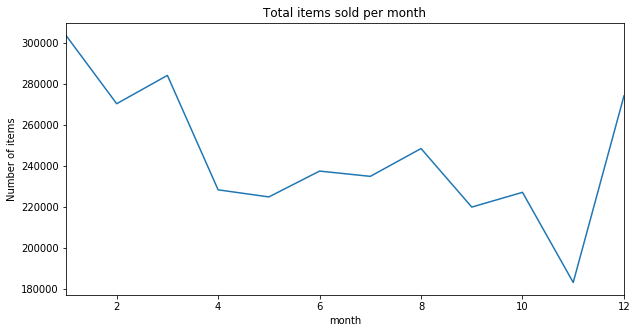

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Total items sold per month")
plt.ylabel('Number of items')
byMonth['item_id'].plot(kind = 'line',ax=ax)

In [10]:
# Creating season column
def select_season(m):
    if m >=1 and m <= 6:
        return 'Q1-Q2'
    else:
        return 'Q3-Q4'


sales['Season'] = sales['month'].apply(select_season)

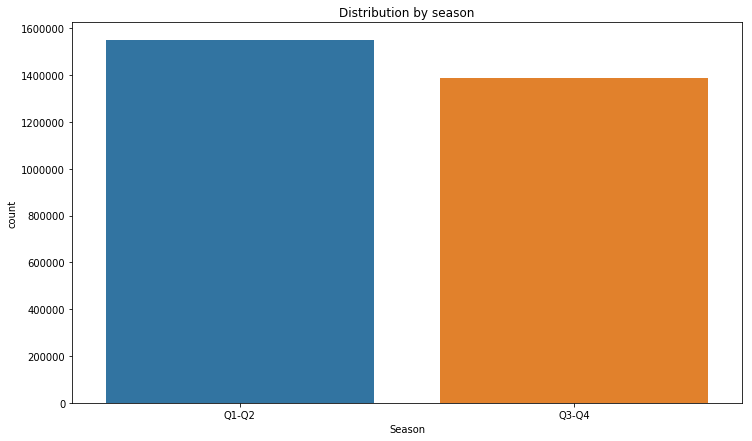

In [11]:
plt.figure(figsize=(12, 7))
plt.title("Distribution by season")
sns.countplot(x='Season',data = sales )

### Merged other supplementary files 

In [12]:
# reading files
path1 = '/Documents/'
items = pd.read_excel(userhome + path1 + 'item_category.xls')
shops = pd.read_excel(userhome + path1 + 'shops.xls')
items_cat = pd.read_csv(userhome + path + 'items.csv')

In [13]:
#merging files into one dataframe
sales1 = pd.merge(sales,items,on='item_id',how='left')
sales1 = pd.merge(sales1,items_cat,on='item_id',how='left')
sales1 = pd.merge(sales1,shops,on='shop_id',how='left')

In [14]:
sales1.rename(columns={'Name': 'Shop_Name', 'item_name_translated': 'item_name','Type': 'Shop_Type' },inplace=True)

In [15]:
#checking missing values or nulls 
sales1.iloc[:,:].isnull().any()


date                False
date_block_num      False
shop_id             False
item_id             False
item_price          False
item_cnt_day        False
year                False
month               False
DOW                 False
Season              False
item_name           False
item_category       False
Item Type           False
item_name           False
item_category_id    False
City                False
Shop_Type           False
Shop_Name           False
dtype: bool

### Calculated item per month by aggregating item count per day records based on item id and shop id and month

In [16]:
index_col = ['item_id','month','shop_id','year','item_category']

In [17]:
# copying data
sales2 = sales1

In [18]:
# dropping duplicated based on index columns
sales2.drop_duplicates(subset=['item_id','month','shop_id','year','item_category'],inplace=True)

In [19]:
# Calculating item count per month . This will reduce the count of records and will give the per month sales of each item 
index_col = ['item_id','month','shop_id','year','item_category']
item_month = sales1.groupby(index_col)['item_cnt_day'].agg(['sum']).reset_index().rename(columns = {'sum': 'item_cnt_month'})
item_month['item_cnt_month'] = item_month['item_cnt_month'].astype(np.int)

In [20]:
#Merging back to sales2
sales2 = pd.merge(sales2,item_month,how='left',on=index_col).fillna(0)
sales2['item_cnt_month'] = sales2['item_cnt_month'].astype(int)

In [21]:
# deleting columns as they are no longer needed
sales2 = sales2.drop(['date','DOW','item_category_id'],axis=1)

In [22]:
#copying data
sales3 = sales2

### Kept only  Moscow shops...count reduced to around 500,000

In [23]:
sales3 = sales3[sales3['City']=='Moscow']

In [24]:
# deleting columns as they are no longer needed
sales3 = sales3.drop(['item_cnt_day'],axis=1)

In [25]:
sales3 = sales3.loc[:, ~sales3.columns.duplicated()]

### Focussing on the items of just one shop of a particular city. Thereby reducing the count to around 40K

In [26]:
sales3.head()

,date_block_num,shop_id,item_id,item_price,year,month,Season,item_name,item_category,Item Type,City,Shop_Type,Shop_Name,item_cnt_month
1,0,25,2552,899.00,2013,1,Q1-Q2,DEEP PURPLE The House Of Blue Light LP,Music,Non Electronics,Moscow,TRC,Atrium,1
2,0,25,2554,1709.05,2013,1,Q1-Q2,DEEP PURPLE Who Do You Think We Are LP,Music,Non Electronics,Moscow,TRC,Atrium,1
3,0,25,2555,1099.00,2013,1,Q1-Q2,DEEP PURPLE 30 Very Best Of 2CD (___ü„Û__.),Music,Non Electronics,Moscow,TRC,Atrium,1
4,0,25,2564,349.00,2013,1,Q1-Q2,DEEP PURPLE Perihelion: Live In Concert DVD (_...,Music,Non Electronics,Moscow,TRC,Atrium,1
5,0,25,2565,549.00,2013,1,Q1-Q2,DEEP PURPLE Stormbringer („ã_ü„Û__.),Music,Non Electronics,Moscow,TRC,Atrium,1


In [27]:
# Filtering just shop 25 -- shop name Atrium
sales4 = sales3.loc[sales3['shop_id']== 25]

In [28]:
#checking missing values or nulls 
sales4.iloc[:,:].isnull().any()

date_block_num    False
shop_id           False
item_id           False
item_price        False
year              False
month             False
Season            False
item_name         False
item_category     False
Item Type         False
City              False
Shop_Type         False
Shop_Name         False
item_cnt_month    False
dtype: bool

In [29]:
sales4 = sales4.drop(['City','Shop_Name'],axis=1)

In [30]:
sales4 = sales4.drop(['date_block_num','shop_id','item_id','item_name'],axis=1)

In [31]:
sales4 = sales4.drop(['Shop_Type'],axis=1)

In [32]:
sales4 = sales4.drop(['month'],axis=1)

In [33]:
sales4.head()

,item_price,year,Season,item_category,Item Type,item_cnt_month
1,899.00,2013,Q1-Q2,Music,Non Electronics,1
2,1709.05,2013,Q1-Q2,Music,Non Electronics,1
3,1099.00,2013,Q1-Q2,Music,Non Electronics,1
4,349.00,2013,Q1-Q2,Music,Non Electronics,1
5,549.00,2013,Q1-Q2,Music,Non Electronics,1


In [34]:
# Removing columns which are not required for further processing
sales4 = sales4[sales4['item_category']!='Clean media (piece)']
sales4 = sales4[sales4['item_category']!='Clean carriers (spire)']
sales4 = sales4[sales4['item_category']!='Tickets (figure)']
sales4 = sales4[sales4['item_category']!='PC']

In [35]:
sales4.replace(['Payment cards','Payment cards (Movies, Music, Games)'],['Vouchers','Vouchers'],inplace=True)

In [36]:
# Calculating sales of each it
def salesvolume(cols):
    item_price = cols[0]
    item_cnt_month = cols[1]
    sales = item_price * item_cnt_month
    return sales
    
    
sales4['Sales_vol'] = sales4[['item_price','item_cnt_month']].apply(salesvolume,axis=1)

In [37]:

#sales4['month'] = sales4['month'].astype('str')
sales4['year'] = sales4['year'].astype('str')


In [38]:
# Converting into numerals
sales4['Season'] = sales4['Season'].astype('category')
def season(s):
    if s == 'Q1-Q2':
        return 1
    else:
        return 0
    
sales4['Season'] = sales4['Season'].apply(season)
        
    

In [39]:
# splitting into X and Y
X = sales4.drop(['Season'],axis=1)
Y = sales4['Season']

In [40]:
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [41]:

X['Item Type'] = X['Item Type'].astype('category')

In [42]:
X['item_category'] = X['item_category'].astype('category')

In [43]:
X['year'] = X['year'].astype('category')

### Dummy variables 

In [44]:
# creating dummy variables
X = pd.get_dummies(X)

In [45]:
# Dropping  reference dummy columns
X = X.drop(['year_2013','Item Type_Non Electronics','item_category_Vouchers'],axis=1)

### Standardizing numeric variables

In [46]:
#Standardizing numeric columns
scaler = preprocessing.StandardScaler().fit(X[["item_price","item_cnt_month","Sales_vol"]])

In [47]:
print(scaler.mean_,scaler.scale_)

[ 732.98642665    1.10286572  902.58294081] [  1.30984284e+03   1.60379001e+00   6.98106817e+03]


In [48]:
#Transforming numeric columns
X_scaled = scaler.transform(X[["item_price","item_cnt_month","Sales_vol"]]) 

In [49]:
columns = ['item_price_s','item_cnt_month_s','Sales_vol_s']
X_Scaled_df = pd.DataFrame(X_scaled.reshape(len(X_scaled),-1),columns=columns)

In [50]:
print(X_scaled.mean(axis=0))
print(X_scaled.std(axis=0))

[  4.91473343e-17  -5.17340361e-17  -2.58670181e-18]
[ 1.  1.  1.]


In [51]:
#Concatenating scaled data with main dataframe
X = pd.concat([X,X_Scaled_df],axis=1) 

In [52]:
#Dropping original numeric columns
X = X.drop(["item_price","item_cnt_month"],axis=1)

In [53]:
#Dropping original numeric columns
X = X.drop(["Sales_vol"],axis=1)

### Shuffling and splitting data into train and test records

In [54]:
#Shuffling data
X_shuffle, Y_shuffle = shuffle(X, Y, random_state=121)

In [55]:
#Splitting data into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X_shuffle, Y_shuffle, test_size=0.20, random_state=121)

In [56]:
#checking any missing record
X_train.iloc[:,:].isnull().any()

year_2014                      False
year_2015                      False
item_category_Accessories      False
item_category_Battery          False
item_category_Books            False
item_category_Cinema           False
item_category_Game Consoles    False
item_category_Games            False
item_category_Gifts            False
item_category_Music            False
item_category_Office           False
item_category_Official         False
item_category_Programs         False
Item Type_Electronics          False
item_price_s                   False
item_cnt_month_s               False
Sales_vol_s                    False
dtype: bool

In [57]:
# saving files to train data
X_train.to_csv('X_train_v2.csv')
Y_train.to_csv('Y_train_v2.csv')
X_test.to_csv('X_test_v2.csv')
Y_test.to_csv('Y_test_v2.csv')
